# Generate atmospheric parameters

In [317]:
import matplotlib.pyplot as plt
import mpl_toolkits.mplot3d as plt3d
import numpy as np
import os
import matplotlib as mpl
import pandas as pd
import itertools

from astropy import units as u
from astropy.coordinates import Angle

import time
from datetime import datetime,date
import dateutil.parser
import pytz

import argparse

import logging
import coloredlogs
import configparser


In [318]:
from astropy.io import fits

In [319]:
from scipy.stats import rayleigh,beta,gamma,uniform

In [320]:
# to enlarge the sizes
params = {'legend.fontsize': 'x-large',
          'figure.figsize': (10,6),
         'axes.labelsize': 'x-large',
         'axes.titlesize':'x-large',
         'xtick.labelsize':'x-large',
         'ytick.labelsize':'x-large'}
plt.rcParams.update(params)

In [321]:
def SimulateValues(n,distrib_name,a,b,loc,scale):
    """
    """
    if distrib_name == 'rayleigh':
        simdata=rayleigh.rvs(loc, scale=scale,size=n)
    elif distrib_name == 'beta':
        simdata=beta.rvs(a=a,b=b,loc=loc, scale=scale,size=n)
    elif distrib_name == 'gamma':
        simdata=gamma.rvs(a=a,loc=loc, scale=scale,size=n)
    else:
        simdata=uniform.rvs(loc=loc,scale=scale,size=n)
        
    return simdata
    

In [322]:
# date
today = date.today()
string_date = today.strftime("%Y-%m-%d")


# time
now = datetime.now()
current_time = now.strftime("%H:%M:%S")

tim = time.localtime()
current_time = time.strftime("%H:%M:%S", tim)



#timezones
tz_LA = pytz.timezone('America/Los_Angeles')
datetime_LA = datetime.now(tz_LA)
print("LA time:", datetime_LA.strftime("%H:%M:%S"))


tz_NY = pytz.timezone('America/New_York')
datetime_NY = datetime.now(tz_NY)
print("NY time:", datetime_NY.strftime("%H:%M:%S"))

tz_London = pytz.timezone('Europe/London')
datetime_London = datetime.now(tz_London)
print("London time:", datetime_London.strftime("%H:%M:%S"))

tz_Paris = pytz.timezone('Europe/Paris')
datetime_Paris = datetime.now(tz_Paris)
print("Paris time:", datetime_Paris.strftime("%H:%M:%S"))



LA time: 15:18:23
NY time: 18:18:23
London time: 23:18:23
Paris time: 00:18:23


In [323]:
# start with logs
#-----------------
logging.basicConfig()
logging.root.setLevel(logging.NOTSET)

handle = __name__

logger = logging.getLogger(handle)
# logging.getLogger().setLevel(logging.INFO)
logger.setLevel(logging.DEBUG)

# If you don't want to see log messages from libraries, you can pass a
# specific logger object to the install() function. In this case only log
# messages originating from that logger will show up on the terminal.
coloredlogs.install(level='DEBUG', logger=logger)
coloredlogs.install(fmt='%(asctime)s,%(msecs)03d %(hostname)s %(name)s[%(process)d] %(levelname)s %(message)s')

In [324]:
# arguments
#----------


parser = argparse.ArgumentParser()
parser.add_argument("--config",action="store", dest="configfile",help=f" run generate -config configfilename, with by ex configfilename = default.ini")
#results_args = parser.parse_args()

results_args=""
   

In [325]:
msg = f"Start {parser.prog} at date : {string_date} and time :{current_time} and with arguments:{results_args}"
logger.info(msg)

2020-09-11 00:18:23,579 MacBook-Pro-de-admin.local __main__[88331] INFO Start ipykernel_launcher.py at date : 2020-09-11 and time :00:18:23 and with arguments:


In [326]:
# config file
# --------------
configfile = "config/default.ini"

#config_filename = results_args.configfile
config_filename = configfile
msg = f"Configuration file : {config_filename}"
logger.info(msg)

2020-09-11 00:18:23,586 MacBook-Pro-de-admin.local __main__[88331] INFO Configuration file : config/default.ini


In [327]:
# 1) CONFIGURATION
#------------------
logger.info('1) Configuration')

config = configparser.ConfigParser()

if os.path.exists(config_filename):
    config.read(config_filename)
else:
    msg = f"config file {config_filename} does not exist !"
    logger.error(msg)

config_section = config.sections()

2020-09-11 00:18:23,593 MacBook-Pro-de-admin.local __main__[88331] INFO 1) Configuration


In [328]:
if len(config_section) == 0:
    msg = f"empty config file {config_filename} !"
    logger.error(msg)    

In [329]:
if 'GENERAL' in config_section:

    FLAG_DEBUG = bool(config['GENERAL']['FLAG_DEBUG'])
    FLAG_VERBOSE = bool(config['GENERAL']['FLAG_VERBOSE'])
    FLAG_PLOT = bool(config['GENERAL']['FLAG_PLOT'])
    FLAG_PRINT = bool(config['GENERAL']['FLAG_PRINT'])
    output_file = config['GENERAL']['outputfile']
    NSIM = int(config['GENERAL']['NSIM'])
else:
    msg = f"empty section GENERAL in config file {config_filename} !"
    logger.error(msg)

In [330]:
NSIM

20000

In [331]:
if 'AEROSOL' in config_section:
    distrib_name = config['AEROSOL']['distrib']
    a=float(config['AEROSOL']['a'])
    b=float(config['AEROSOL']['b'])
    loc=float(config['AEROSOL']['loc'])
    scale=float(config['AEROSOL']['scale'])

In [332]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
VAOD = simdata

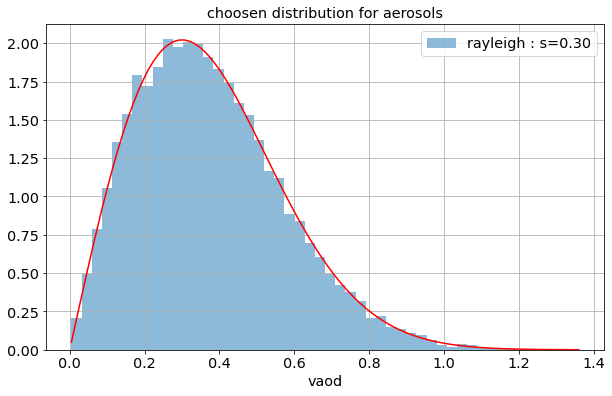

In [333]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='rayleigh':
        rv=rayleigh(loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    label="rayleigh : s={:2.2f}".format(scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=label);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("vaod")
    ax.set_title("choosen distribution for aerosols")

In [334]:
if 'OZONE' in config_section:
    distrib_name = config['OZONE']['distrib']
    a=float(config['OZONE']['a'])
    b=float(config['OZONE']['b'])
    loc=float(config['OZONE']['loc'])
    scale=float(config['OZONE']['scale'])

In [335]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
O3 = simdata

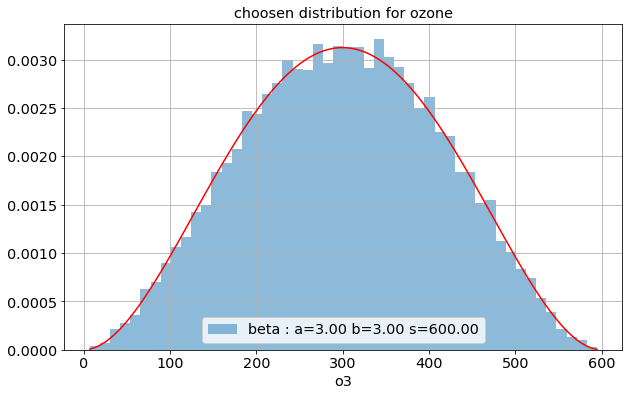

In [336]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    labelb="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=labelb);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("o3")
    ax.set_title("choosen distribution for ozone")

In [337]:
if 'PWV' in config_section:
    distrib_name = config['PWV']['distrib']
    a=float(config['PWV']['a'])
    b=float(config['PWV']['b'])
    loc=float(config['PWV']['loc'])
    scale=float(config['PWV']['scale'])

In [338]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
PWV = simdata

In [339]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
PWV = simdata

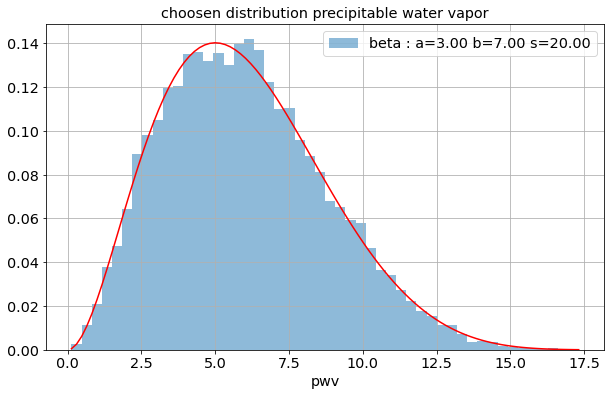

In [340]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    label="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=label);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("pwv")
    ax.set_title("choosen distribution precipitable water vapor")

In [341]:
if 'CLOUD' in config_section:
    distrib_name = config['CLOUD']['distrib']
    a=float(config['CLOUD']['a'])
    b=float(config['CLOUD']['b'])
    loc=float(config['CLOUD']['loc'])
    scale=float(config['CLOUD']['scale'])

In [342]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
CLD = simdata

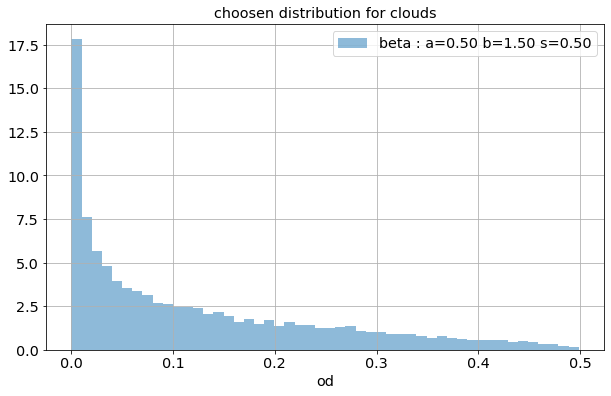

In [343]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    label="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=label);
    #ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("od")
    ax.set_title("choosen distribution for clouds")

In [344]:
if 'AIRMASS' in config_section:
    distrib_name = config['AIRMASS']['distrib']
    a=float(config['AIRMASS']['a'])
    b=float(config['AIRMASS']['b'])
    loc=float(config['AIRMASS']['loc'])
    scale=float(config['AIRMASS']['scale'])

In [345]:
simdata=SimulateValues(NSIM,distrib_name,a,b,loc,scale)
AIRMASS = simdata

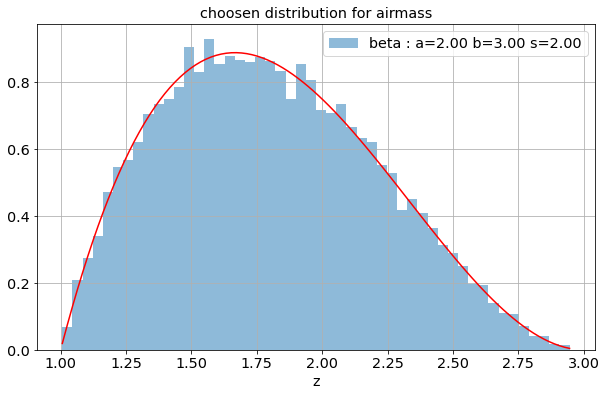

In [346]:
if FLAG_PLOT:
    x=np.linspace(simdata.min(),simdata.max(),100)
    if distrib_name=='beta':
        rv=beta(a=a,b=b,loc=loc, scale=scale)
    
    fig=plt.figure()
    ax=fig.add_subplot(111)
    labelb="beta : a={:2.2f} b={:2.2f} s={:2.2f}".format(a,b,scale)
    ax.hist(simdata,bins=50,density=True, histtype='stepfilled', alpha=0.5,label=labelb);
    ax.plot(x,rv.pdf(x),"r-")
    ax.grid()
    ax.legend()
    ax.set_xlabel("z")
    ax.set_title("choosen distribution for airmass")